# Table of Contents
---
- [Imports](#Imports)
- [Reading in Data](#Reading-in-Data)
- [Cleaning](#Cleaning)
- [Preprocessing Text Data](#Preprocessing-Text-Data)
- [Train-Test-Split](#Train-Test-Split)
- [Modeling](#Modeling)
- [Model Selection and Conclusion](#Model-Selection-and-Conclusion)

## Imports

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import text
from sklearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

## Reading in Data
---
Reading in twitch and youtube dataframes and combining them into one dataframe

In [2]:
# reading in data
twitch = pd.read_csv('../data/twitch_df_full.csv')
youtube = pd.read_csv('../data/youtube_df_full.csv')

tw_df = twitch[['subreddit','selftext']]
yt_df = youtube[['subreddit','selftext']]

df = tw_df.append(yt_df,ignore_index=True)

C:\Users\clare\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8,84) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Cleaning
---
After inspecting the word_count and string length I ended up dropping only observations for which the word count was less than 7, and index 1959 (maximum word count of 4,048 words). These were dropped because:
- observations with up to 7 words indicated either:
    - had the main message/question in the title.
    - contained external links
- index 1,959 was a rant unrelated to reddit/youtube.

In [3]:
# getting word count and string length
def get_word_count(string):
    return len(string.split())

def get_str_length(string):
    return len(string)

df['string_length'] = df['selftext'].map(get_str_length)
df['word_count'] = df['selftext'].map(get_word_count)

df['word_count'].describe(), df['word_count'].mode()

(count    20053.000000
 mean        71.497781
 std         79.168200
 min          1.000000
 25%         28.000000
 50%         52.000000
 75%         90.000000
 max       4048.000000
 Name: word_count, dtype: float64,
 0    3
 dtype: int64)

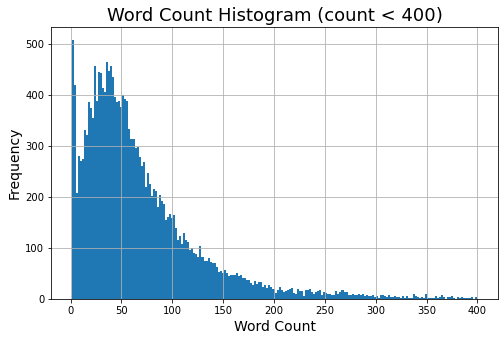

In [4]:
# word count histogram
plt.figure(figsize=(8,5))
df[df['word_count']<=400]['word_count'].plot(kind='hist', bins = 200);
plt.title(label='Word Count Histogram (count < 400)', fontdict={'size':18});
plt.xlabel(xlabel='Word Count', fontdict={'size':14});
plt.ylabel(ylabel='Frequency', fontdict={'size':14});
plt.grid(b=True);

In [5]:
selftext_less_than_7 = df[df['word_count']<=7].index

df.drop(index=selftext_less_than_7, inplace = True)
df.drop(index=1959, inplace = True)

df.reset_index(drop = True, inplace = True)

## Preprocessing Text Data
---
During pre-processing, I renamed and binarized the target variable, `'subreddit'`, as `'is_twitch'`. Then reset the only dataframe to include only the target and predictor variables `'is_twitch'` and `'selftext'`.
Steps taken to process the data are as follows:
- Expand contractions using method from ([geeksforgeeks.org](https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/))
- Turning all text to lowercase
- Lemmatizing text
- Remove punctuation using method from ([geeksforgeeks.org](https://www.geeksforgeeks.org/python-remove-punctuation-from-string/))

In [6]:
# binarizing target variable and renaming as 'is_twitch'
df['is_twitch'] = df['subreddit'].map({'Twitch':1,'youtube':0})
df = df[['is_twitch','selftext']]

In [7]:
# contractions

#import sys  
#!{sys.executable} -m pip install contractions

import contractions

df['selftext'] = df['selftext'].map(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

In [8]:
# turning all letters to lowercase
df['selftext'] = df['selftext'].map(lambda x: x.lower())

In [9]:
# lemmatizing

lem = WordNetLemmatizer()

df['selftext'] = df['selftext'].map(lambda x:  \
            ' '.join([lem.lemmatize(word) for word in RegexpTokenizer(r'\w+').tokenize(x)]))

In [10]:
# removing punctuation
# https://www.geeksforgeeks.org/python-remove-punctuation-from-string/

df['selftext'] = df['selftext'].map(lambda x: re.sub(r'[^\w\s]','',x))

## Train-Test-Split
---
After performing train-test-split on the predictor variable `'selftext'`, I created a custom list of stopwords to append to the stopwords found in sklearn's `text` module and those built into TF-IDF Vectorizer. X_train and X_test were appropriately fitted and transformed, and turned into dataframes for EDA.

In [11]:
# defining X and y
X = df['selftext']
y = df['is_twitch']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    stratify = y,
                                                    random_state = 42)

In [12]:
# stop words
tw_yt_stop_words = ['twitch','ttv','youtube','yt','http','https','www','com','amp','jpeg','png',
                    'reddit','redd','dont','like','just','want','doe','ha','wa','rtwitch','ryoutube']
stop_words = text.ENGLISH_STOP_WORDS.union(tw_yt_stop_words)
stop_words = stop_words.union(TfidfVectorizer(stop_words='english').get_stop_words())

In [13]:
# tvec
tvec = TfidfVectorizer(stop_words = stop_words,
                      min_df = 3,
                      max_features = 50000,
                      strip_accents = 'ascii',
                      ngram_range = (1, 3))

In [14]:
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                            columns = tvec.get_feature_names())

X_test_tvec = pd.DataFrame(tvec.transform(X_test).todense(),
                            columns = tvec.get_feature_names())

### Most common words in overall train data and twitch/youtube data
---
Below are three plots of the sums of TF-IDF scores for three sets contained in the train data set. The first figure shows the 25 most common words in the train data. The next two shows words unique to the twich and youtube subreddits. Because two subreddits are closely related, I determined that both subreddits largely shared the same words based on two things:
- the scale of the TF-IDF scores for words unique to the subreddits is substantially lower than those for the whole train data set
- when dissecting the X_train_tvec, it took looking over 2,000 of the most common words in generate about 300 unique words for the respective subreddits.

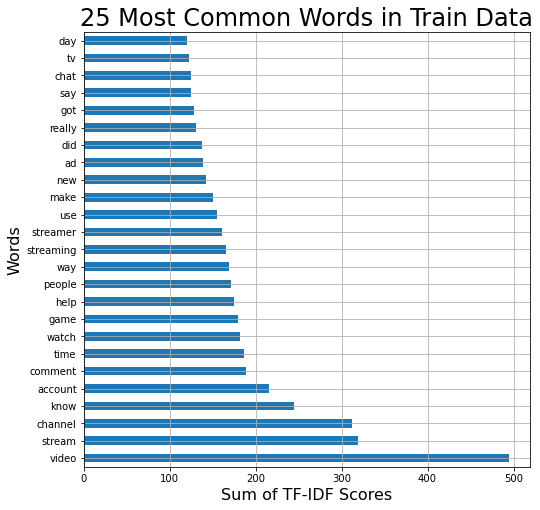

In [15]:
# 25 most common words in train data
plt.figure(figsize=(8,8));
X_train_tvec.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.title(label = '25 Most Common Words in Train Data', fontdict = {'size':24});
plt.xlabel(xlabel = 'Sum of TF-IDF Scores', fontdict = {'size':16});
plt.ylabel(ylabel = 'Words', fontdict = {'size':16});
plt.grid(b = True);

In [16]:
# dissecting X_train_tvec to get most common words by subreddit
twitch_2k = X_train_tvec[df['is_twitch']==1].sum().sort_values(ascending=False)[:2000]
youtube_2k = X_train_tvec[df['is_twitch']==0].sum().sort_values(ascending=False)[:2000]

words_in_both = [i for i in twitch_2k.index if i in youtube_2k.index]
twitch_2k_not_in_yt = [i for i in twitch_2k.index if i not in youtube_2k.index]
yt_2k_not_in_twitch = [i for i in youtube_2k.index if i not in twitch_2k.index]

words_in_both_df = pd.DataFrame(words_in_both, columns =['both'])
tw_wc_df = pd.DataFrame(twitch_2k_not_in_yt, columns =['tw'])
yt_wc_df = pd.DataFrame(yt_2k_not_in_twitch, columns =['yt'])

<ipython-input-16-b9d1cc3a15a5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  twitch_2k = X_train_tvec[df['is_twitch']==1].sum().sort_values(ascending=False)[:2000]
<ipython-input-16-b9d1cc3a15a5>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  youtube_2k = X_train_tvec[df['is_twitch']==0].sum().sort_values(ascending=False)[:2000]


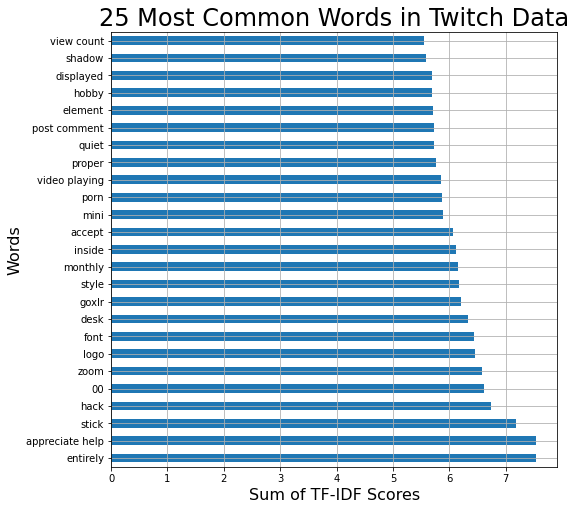

In [17]:
# 25 most common words in Twitch data
plt.figure(figsize=(8,8));
twitch_2k.loc[twitch_2k_not_in_yt].sort_values(ascending=False).head(25).plot(kind='barh');
plt.title(label = '25 Most Common Words in Twitch Data', fontdict = {'size':24});
plt.xlabel(xlabel = 'Sum of TF-IDF Scores', fontdict = {'size':16});
plt.ylabel(ylabel = 'Words', fontdict = {'size':16});
plt.grid(b = True);

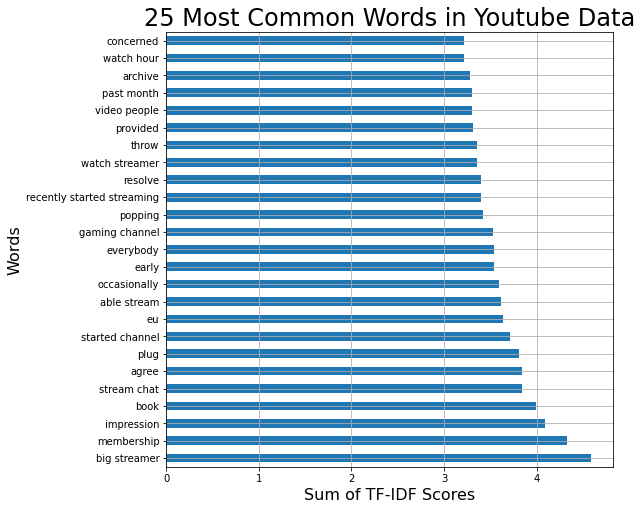

In [18]:
# 25 most common words in Youtube data
plt.figure(figsize=(8,8));
youtube_2k.loc[yt_2k_not_in_twitch].sort_values(ascending=False).head(25).plot(kind='barh');
plt.title(label = '25 Most Common Words in Youtube Data', fontdict = {'size':24});
plt.xlabel(xlabel = 'Sum of TF-IDF Scores', fontdict = {'size':16});
plt.ylabel(ylabel = 'Words', fontdict = {'size':16});
plt.grid(b = True);

## Modeling
---
### Baseline Predictions
Considering I collected equal amounts of data from each subreddit, the null hypothesis only ~50% accuracate in predicting the target variable.

In [19]:
y.value_counts(normalize=True)

1    0.505786
0    0.494214
Name: is_twitch, dtype: float64

## KNN Classifier
---
Below, cross-validated gridsearch yielded test parameters of 701 distance-weighted nearest neighbors. In other words, the closer TF-IDF scores were to the X_test predictor variables, the more greater their effect in determining which subreddit the post belonged to.

This model turned out to be overfit, 99% accurate on the train data, while only 89% accurate on the validation data.

When looking at the normalized confusion matrix for this model, despite having roughly equal number of posts from each subreddit, this model predicts slightly more accurately posts belonging to youtube.

In [23]:
# knn code
knn = KNeighborsClassifier()

knn_params = {
    'n_neighbors':range(651,751,50),
    'weights':['uniform','distance']
}

knn_gs = GridSearchCV(knn,
                     knn_params,
                     cv = 3,
                     verbose = 3)

knn_gs.fit(X_train_tvec, y_train)
knn_gs.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ...............n_neighbors=651, weights=uniform; total time=  16.3s
[CV 2/3] END ...............n_neighbors=651, weights=uniform; total time=  16.3s
[CV 3/3] END ...............n_neighbors=651, weights=uniform; total time=  16.2s
[CV 1/3] END ..............n_neighbors=651, weights=distance; total time=  16.5s
[CV 2/3] END ..............n_neighbors=651, weights=distance; total time=  16.3s
[CV 3/3] END ..............n_neighbors=651, weights=distance; total time=  17.2s
[CV 1/3] END ...............n_neighbors=701, weights=uniform; total time=  17.3s
[CV 2/3] END ...............n_neighbors=701, weights=uniform; total time=  16.6s
[CV 3/3] END ...............n_neighbors=701, weights=uniform; total time=  17.6s
[CV 1/3] END ..............n_neighbors=701, weights=distance; total time=  17.6s
[CV 2/3] END ..............n_neighbors=701, weights=distance; total time=  15.2s
[CV 3/3] END ..............n_neighbors=701, weigh

{'n_neighbors': 701, 'weights': 'distance'}

In [24]:
# knn scores
print('Cross Val Score', cross_val_score(knn,X_train_tvec, y_train, cv = 3,n_jobs=-1).mean())
print('Train Score:', knn_gs.score(X_train_tvec, y_train))
print('Test Score:', knn_gs.score(X_test_tvec, y_test))
print('Best Score:',knn_gs.best_score_)
print('Best Parameters:',knn_gs.best_params_)

Cross Val Score 0.800825008331667
Train Score: 0.999666711105186
Test Score: 0.8898960277259398
Best Score: 0.8778830500566553
Best Parameters: {'n_neighbors': 701, 'weights': 'distance'}


|KNN Scores/Params|Values|
|---|---|
|Cross Val Score|0.5233137742537739|
|Train Score|0.999666711105186|
|Test Score|0.8898960277259398|
|Best Score|0.8778830500566553|
|Best Parameters|{'n_neighbors': 701, 'weights': 'distance'}|

Text(0.5, 1.0, 'KNN Confusion Matrix')

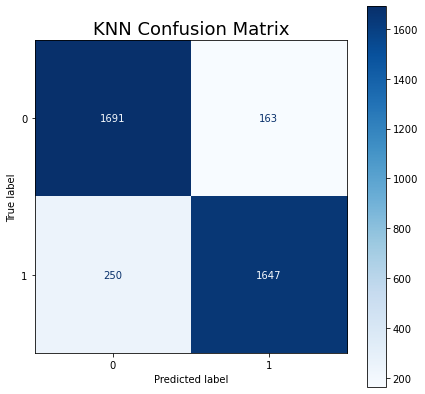

In [26]:
# knn predictions and confusion matrix
knn_preds = knn_gs.predict(X_test_tvec)

cm = confusion_matrix(y_test, knn_preds)
tn, fp, fn, tp = cm.ravel()

fig, axknn1 = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn_gs,
                     X_test_tvec,
                     y_test,
                     cmap = 'Blues',
                     ax = axknn1);
plt.title(label='KNN Confusion Matrix',fontdict={'size':18})

Text(0.5, 1.0, 'KNN Confusion Matrix')

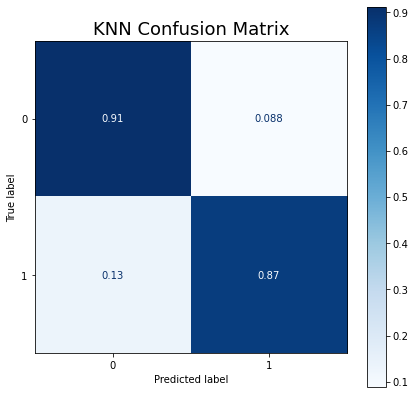

In [27]:
# knn confusion matrix (normalized)
fig, axknn2 = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn_gs,
                     X_test_tvec,
                     y_test,
                     normalize = 'true',
                     cmap = 'Blues',
                     ax = axknn2);
plt.title(label='KNN Confusion Matrix',fontdict={'size':18})

In [28]:
print(classification_report(y_test, knn_preds))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1854
           1       0.91      0.87      0.89      1897

    accuracy                           0.89      3751
   macro avg       0.89      0.89      0.89      3751
weighted avg       0.89      0.89      0.89      3751



|KNN|precision|recall|f1-score|support|
|---|---|---|---|---|
|0|0.93|0.76|0.84|2001|
|1|0.80|0.94|0.86|2010|
|accuracy|   |   |0.85|4011|

## Random Forest Classifier
---
With accuracies of 94% and 91% on the train and validation data respectively, this random forest classifier model performed better than the previous KNN model, showing a lower degree of overfittedness. According to the normalized confusion matrix, it also predicts each subreddit more accurately than the KNN model.

One added benefit of this model is the ability to take a closer look at which features are important in determining the predictions, namely, reducing the likelihood of being mislabeled. Shown below are the top 15 words with the highest feature importance.

In [30]:
# rfc code
rfc = RandomForestClassifier()

rfc_params = {
    'n_estimators':[100],
    'max_depth':[75,100],
    'min_samples_leaf':[3,8],
    'min_samples_split':[5,15]
}

rfc_gs = GridSearchCV(rfc,
                      rfc_params,
                      cv = 3,
                      verbose = 3)

rfc_gs.fit(X_train_tvec, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END max_depth=75, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV 2/3] END max_depth=75, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV 3/3] END max_depth=75, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV 1/3] END max_depth=75, min_samples_leaf=3, min_samples_split=15, n_estimators=100; total time= 1.1min
[CV 2/3] END max_depth=75, min_samples_leaf=3, min_samples_split=15, n_estimators=100; total time= 1.1min
[CV 3/3] END max_depth=75, min_samples_leaf=3, min_samples_split=15, n_estimators=100; total time= 1.1min
[CV 1/3] END max_depth=75, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=  59.5s
[CV 2/3] END max_depth=75, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=  56.0s
[CV 3/3] END max_depth=75, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [75, 100], 'min_samples_leaf': [3, 8],
                         'min_samples_split': [5, 15], 'n_estimators': [100]},
             verbose=3)

In [31]:
# rfc scores
print('Train Score:', rfc_gs.score(X_train_tvec, y_train))
print('Test Score:', rfc_gs.score(X_test_tvec, y_test))
print('Best Score:', rfc_gs.best_score_)
print('Best Parameters:', rfc_gs.best_params_)

Train Score: 0.9390747900279963
Test Score: 0.9176219674753399
Best Score: 0.9071456908618276
Best Parameters: {'max_depth': 100, 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 100}


|RFC_gs Score/Params|Values|
|---|---|
|Train Score|0.9407412345020664|
|Test Score|0.9157557984537457|
|Best Score|0.9067454642404852|
|Best Parameters|{'max_depth': 100, 'min_samples_leaf': 3,  |
||'min_samples_split': 5, 'n_estimators': 100}|

In [32]:
# rfc feature importance
d = {'Column Name':X_train_tvec.columns,
     'Feature Importance':rfc_gs.best_estimator_.feature_importances_}
rfc_gs_fi = pd.DataFrame(d)

rfc_gs_fi.to_csv('../data/rfc_gs_fi.csv',index=False)

rfc_gs_fi.sort_values(by=['Feature Importance'], ascending= False).head(15)

,Column Name,Feature Importance
30918,video,0.098510
25964,stream,0.081172
26509,streamer,0.038428
26691,streaming,0.031369
11010,game,0.020414
31906,viewer,0.017877
5323,chat,0.017088
6069,comment,0.016568
4812,channel,0.014781
18674,ob,0.013077


Text(0.5, 1.0, 'RFC Confusion Matrix')

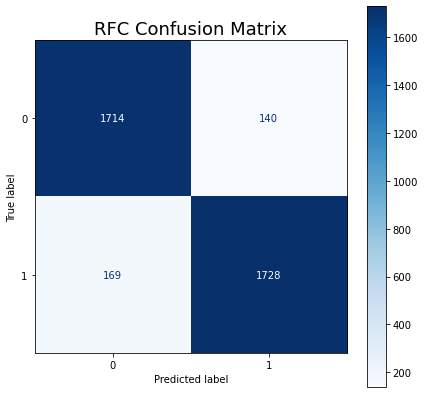

In [34]:
# rfc predictions and confusion matrix
rfc_preds = rfc_gs.predict(X_test_tvec)

cm = confusion_matrix(y_test, rfc_preds)
tn, fp, fn, tp = cm.ravel()

fig, axrfc1 = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rfc_gs,
                     X_test_tvec,
                     y_test,
                     cmap = 'Blues',
                     ax = axrfc1);
plt.title(label='RFC Confusion Matrix',fontdict={'size':18})

Text(0.5, 1.0, 'RFC Confusion Matrix')

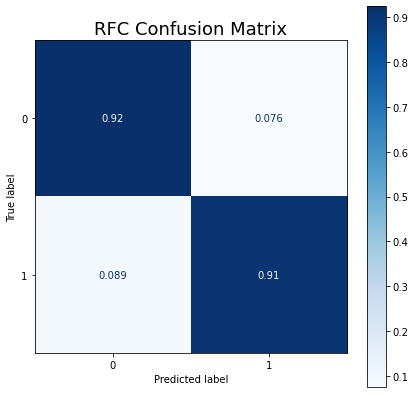

In [35]:
# rfc confusion matrix (normalized)
fig, axrfc2 = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rfc_gs,
                     X_test_tvec,
                     y_test,
                     normalize='true',
                     cmap = 'Blues',
                     ax = axrfc2);
plt.title(label='RFC Confusion Matrix',fontdict={'size':18})

In [36]:
print(classification_report(y_test, rfc_preds))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1854
           1       0.93      0.91      0.92      1897

    accuracy                           0.92      3751
   macro avg       0.92      0.92      0.92      3751
weighted avg       0.92      0.92      0.92      3751



|RFC_gs|precision|recall|f1-score|support|
|---|---|---|---|---|
|0|0.91|0.92|0.92|1854|
|1|0.92|0.81|0.92|1897|
|accuracy|   |   |0.92|3751|

## Multinomial Naive Bayes
---
This model showed an even lower degree of overfittedness, with 92% and 91% accuracies on the train and validation sets respectively. One caveat is that the hyperparameters for this model were all default. Instead, the train and validation data were fitted/transformed using count vectorizer.

In [38]:
# mnb code
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words)),
    ('mnb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [8000,10000],
    'cvec__min_df': [2],
    'cvec__max_df': [0.8, .85],
    'cvec__ngram_range': [(1,3)]
}

mnb_gs = GridSearchCV(pipe,
                 pipe_params,
                 cv = 3,
                 verbose = 3)

mnb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END cvec__max_df=0.8, cvec__max_features=8000, cvec__min_df=2, cvec__ngram_range=(1, 3); total time=   2.4s
[CV 2/3] END cvec__max_df=0.8, cvec__max_features=8000, cvec__min_df=2, cvec__ngram_range=(1, 3); total time=   2.3s
[CV 3/3] END cvec__max_df=0.8, cvec__max_features=8000, cvec__min_df=2, cvec__ngram_range=(1, 3); total time=   2.3s
[CV 1/3] END cvec__max_df=0.8, cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 3); total time=   2.3s
[CV 2/3] END cvec__max_df=0.8, cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 3); total time=   2.3s
[CV 3/3] END cvec__max_df=0.8, cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 3); total time=   2.3s
[CV 1/3] END cvec__max_df=0.85, cvec__max_features=8000, cvec__min_df=2, cvec__ngram_range=(1, 3); total time=   2.3s
[CV 2/3] END cvec__max_df=0.85, cvec__max_features=8000, cvec__min_df=2, cvec__ngram_range=(1, 3); total time=   2.3s

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                            

In [39]:
# mnb scores
print('Train Score:', mnb_gs.score(X_train, y_train))
print('Test Score:', mnb_gs.score(X_test, y_test))
print('Best Score:', mnb_gs.best_score_)
print('Best Parameters:', mnb_gs.best_params_)

Train Score: 0.9216771097187042
Test Score: 0.9162889896027726
Best Score: 0.9043462507498501
Best Parameters: {'cvec__max_df': 0.8, 'cvec__max_features': 10000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3)}


|MNB_gs Score/Params|Values|
|---|---|
|Train Score|0.9216771097187042|
|Test Score|0.9162889896027726|
|Best Score|0.9043462507498501|
|Best Parameters|{'cvec__max_df': 0.8, 'cvec__max_features': 10000,  |
||'cvec__min_df': 2, 'cvec__ngram_range': (1, 3)}|

Text(0.5, 1.0, 'MNB Confusion Matrix')

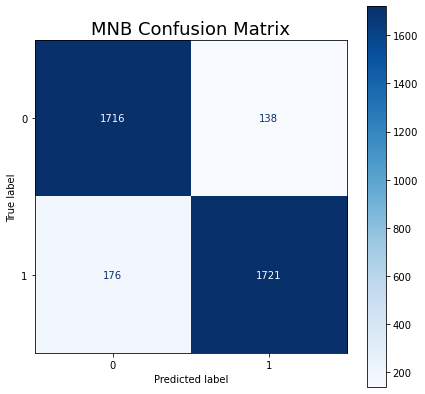

In [42]:
# mnb predictions and confusion matrix
mnb_preds = mnb_gs.predict(X_test)

cm = confusion_matrix(y_test, mnb_preds)
tn, fp, fn, tp = cm.ravel()

fig, axmnb1 = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(mnb_gs,
                     X_test,
                     y_test,
                     cmap = 'Blues',
                     ax = axmnb1);
plt.title(label='MNB Confusion Matrix',fontdict={'size':18})

Text(0.5, 1.0, 'MNB Confusion Matrix')

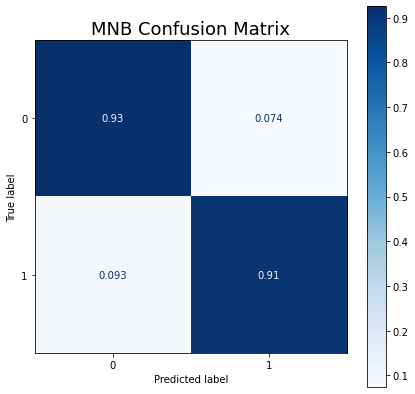

In [43]:
# mnb confusion matrix (normalized)
fig, axmnb2 = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(mnb_gs,
                     X_test,
                     y_test,
                     normalize='true',
                     cmap = 'Blues',
                     ax = axmnb2);
plt.title(label='MNB Confusion Matrix',fontdict={'size':18})

In [44]:
print(classification_report(y_test, mnb_preds))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1854
           1       0.93      0.91      0.92      1897

    accuracy                           0.92      3751
   macro avg       0.92      0.92      0.92      3751
weighted avg       0.92      0.92      0.92      3751



|MNB_gs|precision|recall|f1-score|support|
|---|---|---|---|---|
|0|0.91|0.93|0.92|1854|
|1|0.93|0.91|0.92|1897|
|accuracy|   |   |0.92|3751|

## Model Selection and Conclusion
---
In selecting a model to best predict whether a random post belongs to the twitch or youtube subreddit, I recommend choosing the Random Forest Classifier model. The reason for this is two-fold:
1. It performed better than the KNN classifier, with a lower degree of overfittedness.
2. It had virtually the same accuracy on the validation data as the Multinomial Naive Bayes model, but also includes the option of further analyzing the most important words and phrases that contributed to predictions. In general, I believe this option gives users more value than a minute increase in accuracy or reduction in overfittedness.